<a href="https://colab.research.google.com/github/zahraDehghanian97/DP-FedAvg/blob/master/DP_FedAvg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#FedAvg

simulate a distributed learning scenario with multiple clients and a central server.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler

# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)



100%|██████████| 170498071/170498071 [00:02<00:00, 60656547.68it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Partition the dataset across clients
num_clients = 4
client_indices = [list(range(i * len(trainset) // num_clients, (i + 1) * len(trainset) // num_clients)) for i in range(num_clients)]

# Create DataLoaders for each client
client_loaders = [DataLoader(trainset, batch_size=64, sampler=SubsetRandomSampler(indices)) for indices in client_indices]

# Create a DataLoader for the test dataset
test_loader = DataLoader(testset, batch_size=64, shuffle=True)

implement FedAvg

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
def train_client(client_loader, global_model, local_epochs=1):
    local_model = SimpleCNN()
    local_model.load_state_dict(global_model.state_dict())
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(local_model.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(local_epochs):
        for i, data in enumerate(client_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = local_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    return local_model.state_dict()

In [ ]:
def aggregate_models(global_model, client_models, client_loaders):
    total_samples = sum([len(loader.dataset) for loader in client_loaders])
    avg_state_dict = global_model.state_dict()

    for key in avg_state_dict.keys():
        avg_state_dict[key] = torch.stack([client_models[i][key] * len(client_loaders[i].dataset) / total_samples for i in range(len(client_models))], dim=0).sum(dim=0)

    global_model.load_state_dict(avg_state_dict)
    return global_model


In [ ]:
def test_model(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

train model on fixed number of rounds

In [ ]:
global_model = SimpleCNN()
num_rounds = 30
local_epochs = 1

for round in range(num_rounds):
    client_models = [train_client(client_loader, global_model, local_epochs) for client_loader in client_loaders]
    global_model = aggregate_models(global_model, client_models, client_loaders)
    accuracy = test_model(global_model, test_loader)
    print(f"Round {round + 1}: Global model accuracy: {accuracy:.4f}")

Round 1: Global model accuracy: 0.0989
Round 2: Global model accuracy: 0.1020
Round 3: Global model accuracy: 0.1068
Round 4: Global model accuracy: 0.1701
Round 5: Global model accuracy: 0.1943
Round 6: Global model accuracy: 0.1806
Round 7: Global model accuracy: 0.1974
Round 8: Global model accuracy: 0.2339
Round 9: Global model accuracy: 0.2772
Round 10: Global model accuracy: 0.3047
Round 11: Global model accuracy: 0.3284
Round 12: Global model accuracy: 0.3430
Round 13: Global model accuracy: 0.3626
Round 14: Global model accuracy: 0.3837
Round 15: Global model accuracy: 0.4012
Round 16: Global model accuracy: 0.4102
Round 17: Global model accuracy: 0.4211
Round 18: Global model accuracy: 0.4261
Round 19: Global model accuracy: 0.4365
Round 20: Global model accuracy: 0.4434
Round 21: Global model accuracy: 0.4493
Round 22: Global model accuracy: 0.4546
Round 23: Global model accuracy: 0.4603
Round 24: Global model accuracy: 0.4682
Round 25: Global model accuracy: 0.4729
Round 26:

#DP-FedAvg

In [27]:
from torch.distributions.laplace import Laplace

def train_client_dp(client_loader, global_model, local_epochs,delta,epsilon):
    local_model = SimpleCNN()
    local_model.load_state_dict(global_model.state_dict())
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(local_model.parameters(), lr=0.001, momentum=0.9)
    for epoch in range(local_epochs):
        for i, data in enumerate(client_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = local_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        # # Add Laplace noise to the client model
        for param in local_model.parameters():
            noise = Laplace(0, 2 * len(client_loader.dataset) * delta /epsilon)
            param.data.add_(noise.sample())

    return local_model.state_dict()


In [ ]:
import numpy as np

def aggregate_models_dp(global_model, client_models, client_loaders,delta,epsilon):
    # Aggregate the client models with differential privacy
    total_samples = sum([len(loader.dataset) for loader in client_loaders])
    avg_state_dict = global_model.state_dict()
    for key in avg_state_dict.keys():
        noise = Laplace(0, 2 * delta / epsilon)
        noise_term = noise.sample(avg_state_dict[key].shape)
        avg_state_dict[key] = torch.stack([client_models[i][key] * len(client_loaders[i].dataset) / total_samples for i in range(len(client_models))], dim=0).sum(dim=0) + noise_term
    global_model.load_state_dict(avg_state_dict)

    return global_model


tune parameter and train model on same number of rounds 

In [28]:
global_model_dp = SimpleCNN()
num_rounds = 30
local_epochs = 1
epsilon = 1.0
delta = 0.002

for round in range(num_rounds):
    client_models = [train_client_dp(client_loader, global_model_dp, local_epochs,delta,epsilon) for client_loader in client_loaders]
    global_model_dp = aggregate_models_dp(global_model_dp, client_models, client_loaders,delta,epsilon)
    accuracy = test_model(global_model_dp, test_loader)
    print(f"Round {round + 1}: Global (DP-FedAvg) model dp accuracy: {accuracy:.4f}")

Round 1: Global (DP-FedAvg) model dp accuracy: 0.1040
Round 2: Global (DP-FedAvg) model dp accuracy: 0.1175
Round 3: Global (DP-FedAvg) model dp accuracy: 0.1197
Round 4: Global (DP-FedAvg) model dp accuracy: 0.1180
Round 5: Global (DP-FedAvg) model dp accuracy: 0.1280
Round 6: Global (DP-FedAvg) model dp accuracy: 0.1690
Round 7: Global (DP-FedAvg) model dp accuracy: 0.2136
Round 8: Global (DP-FedAvg) model dp accuracy: 0.2279
Round 9: Global (DP-FedAvg) model dp accuracy: 0.2445
Round 10: Global (DP-FedAvg) model dp accuracy: 0.2620
Round 11: Global (DP-FedAvg) model dp accuracy: 0.2799
Round 12: Global (DP-FedAvg) model dp accuracy: 0.2921
Round 13: Global (DP-FedAvg) model dp accuracy: 0.3072
Round 14: Global (DP-FedAvg) model dp accuracy: 0.3169
Round 15: Global (DP-FedAvg) model dp accuracy: 0.3284
Round 16: Global (DP-FedAvg) model dp accuracy: 0.3421
Round 17: Global (DP-FedAvg) model dp accuracy: 0.3495
Round 18: Global (DP-FedAvg) model dp accuracy: 0.3685
Round 19: Global (D

To evaluate the trade-off between privacy and utility, we can vary the privacy parameter (ϵ) in DP-FedAvg and plot the accuracy-privacy trade-off curve.

Epsilon 0.0001: Global (DP-FedAvg) model accuracy: 0.1000
Epsilon 0.00046415888336127773: Global (DP-FedAvg) model accuracy: 0.2384
Epsilon 0.002154434690031882: Global (DP-FedAvg) model accuracy: 0.3370
Epsilon 0.01: Global (DP-FedAvg) model accuracy: 0.4025
Epsilon 0.046415888336127774: Global (DP-FedAvg) model accuracy: 0.4457
Epsilon 0.21544346900318823: Global (DP-FedAvg) model accuracy: 0.4472
Epsilon 1.0: Global (DP-FedAvg) model accuracy: 0.4353
Epsilon 4.641588833612772: Global (DP-FedAvg) model accuracy: 0.4444
Epsilon 21.54434690031882: Global (DP-FedAvg) model accuracy: 0.4569
Epsilon 100.0: Global (DP-FedAvg) model accuracy: 0.4509
<------------------------------------->
 Global (FedAvg) model accuracy: 0.4603


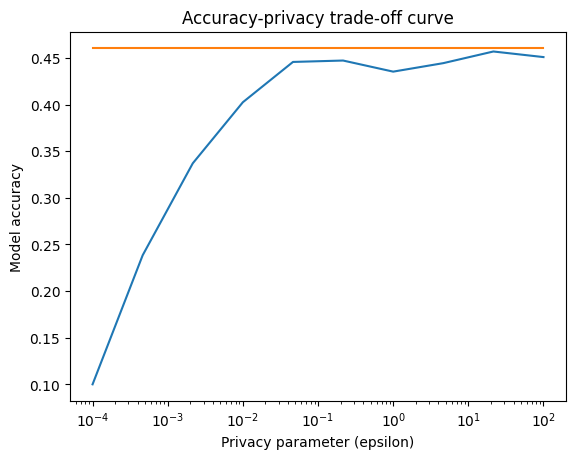

In [9]:
import matplotlib.pyplot as plt
import numpy as np
# Define the range of privacy parameter values to test
epsilons = np.logspace(-4, 2, 10)
num_rounds = 20
local_epochs = 1
delta = 1e-5
accuracies = []

# Evaluate the model accuracy for each epsilon value
for epsilon in epsilons:
  global_model_dp = SimpleCNN()
  for round in range(num_rounds):
    client_models = [train_client_dp(client_loader, global_model_dp, local_epochs,delta,epsilon) for client_loader in client_loaders]
    global_model_dp = aggregate_models_dp(global_model_dp, client_models, client_loaders,delta,epsilon)
  accuracy = test_model(global_model_dp, test_loader)
  print(f"Epsilon {epsilon}: Global (DP-FedAvg) model accuracy: {accuracy:.4f}")
  accuracies.append(accuracy)

print("<------------------------------------->")
global_model = SimpleCNN()
for round in range(num_rounds):
    client_models = [train_client(client_loader, global_model, local_epochs) for client_loader in client_loaders]
    global_model = aggregate_models(global_model, client_models, client_loaders)
accuracy = test_model(global_model, test_loader)
print(f" Global (FedAvg) model accuracy: {accuracy:.4f}")

not_dp_accuracies =[]
for i in range (len(accuracies)):
  not_dp_accuracies.append(accuracy)

# Plot the accuracy-privacy trade-off curve
plt.semilogx(epsilons, accuracies)
plt.semilogx(epsilons, not_dp_accuracies)
plt.xlabel('Privacy parameter (epsilon)')
plt.ylabel('Model accuracy')
plt.title('Accuracy-privacy trade-off curve')
plt.show()

The trade-off between privacy and model accuracy can be discussed by analyzing the accuracy-privacy trade-off curve. Generally, we observe that as the level of privacy protection increases (as ϵ decreases), the model accuracy decreases. This is due to the added noise that is necessary to achieve differential privacy, which reduces the accuracy of the model. 
